# Evaluating Applied Cuts
This notebook will apply some of the rough manual cuts found via research in previous notebooks (and detailed in the lab book). It will then look to evaluate the performance of these cuts across both the simulated data and the real background data from now on simulated data will be referred to as SD and real background data as RD.

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from utilities import Consts, Data, Cut, Plots
%matplotlib inline

In [31]:
SFNAME, SSUFFIX = Consts().get_simulated_tuple()
RFNAME, RSUFFIX = Consts().get_real_tuple()
sd = Data(SFNAME, SSUFFIX)
rd = Data(RFNAME, RSUFFIX)

In [32]:
sdc, rdc = Cut(sd), Cut(rd)

## Implementing Cuts
Now all the initial setup is done we actually apply some of the cuts on the data and plot some of the invariant mass distributions each time to see how this has affected anything. Some basic statistics are also output. Firstly though we fetch the backgroud category feature from the simulated data and categorise all the events so when we plot them we can distinguish them. We define 1 as a signal event and 0 as a background event.

## ProbNN Cuts
The cuts we will be implementing and evaluating are given below (notice firstly we will apply one at a time then reset and then apply the next to evaluate each distinctly). These cuts are phrased such that anything meeting the criteria is retained.
- $P(K=p)\leq0.4921$,
- $P(K=K)\geq0.5398$,
- $P(e=p)\leq0.4306$,
- $P(e=K)\leq0.7197$

In [33]:
rf = rd.fetch_features(['K_ProbNNp'])
sf = sd.fetch_features(['K_ProbNNp', 'Lb_BKGCAT'])

sf['cat'] = np.where(sf['Lb_BKGCAT'].isin([10, 50]), 1, 0)
sf.drop('Lb_BKGCAT', axis=1, inplace=True)
g = sf.groupby('cat')

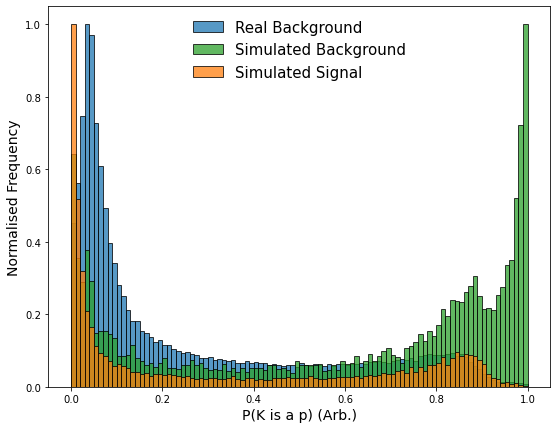

In [61]:

bin_space = np.linspace(0, 1, 101)
bin_width = bin_space[1] - bin_space[0]
bin_centres = [np.mean(bin_space[i:i+2]) for i in range(len(bin_space)-1)]
sdat, rdat, simbg = np.histogram(g.get_group(1)['K_ProbNNp'], bin_space), np.histogram(rf['K_ProbNNp'], bin_space), np.histogram(g.get_group(0)['K_ProbNNp'], bin_space)

sfrq, rfrq, xfrq = sdat[0], rdat[0], simbg[0]
# Get the frequencies from each of the bins (not normalised)
snorm, rnorm, xnorm = np.max(sfrq), np.max(rfrq), np.max(xfrq)
# Calculat the normalisation constants for each 
sfrqn, rfrqn, xfrqn = sfrq/snorm, rfrq/rnorm, xfrq/xnorm
# The normalised frequencies so that all distributions peak at 1

fig, ax = plt.subplots(1, 1, figsize=(9, 7))
ax.bar(bin_centres, rfrqn, width=bin_width,label='Real Background', edgecolor='k', color='#1f77b4', alpha=0.75)
ax.bar(bin_centres, xfrqn, width=bin_width, label='Simulated Background', edgecolor='k', color='#2ca02c', alpha=0.75)
ax.bar(bin_centres, sfrqn, width=bin_width, label='Simulated Signal', edgecolor='k', color='#ff7f0e', alpha=0.75)
ax.set_xlabel('P(K is a p) (Arb.)', fontsize=14)
ax.set_ylabel('Normalised Frequency', fontsize=14)
plt.legend(frameon=False, prop={'size': 15})
plt.savefig('/home/user211/project/images/CutEvaluations/K_ProbNNp_Report.png', dpi=800)
plt.show()


In [51]:
def punzi(original_background, background, signal):
    """
    Returns the Punzi figure of merit given some background and signal no. of events
    """
    efficiency = signal/original_background
    return efficiency/(2.5 + np.sqrt(background))

def probnn(data, particle, p, on):
    """
    Does a ProbNN cut, keep data less than critical value
    """
    feature_of_interest = on + '_ProbNN' + particle
    return data.loc[data[feature_of_interest] < p]

def sb_fom(background, signal):
    return signal/np.sqrt(background), signal/np.sqrt(signal + background)

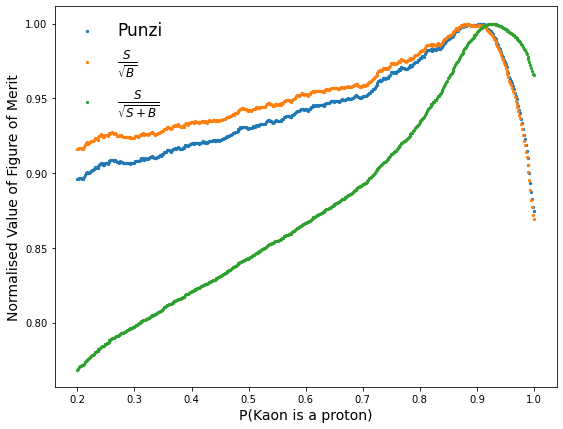

In [59]:
cut_range = np.linspace(0.2, 1, 500)
original_bg = len(g.get_group(0))

bg = []
sig = []
for i in cut_range:
    bg.append(len(probnn(g.get_group(0), 'p', i, 'K')))
    sig.append(len(probnn(g.get_group(1), 'p', i, 'K')))

punzis = [punzi(original_bg, bg[i], sig[i]) for i in range(len(bg))]
soverb = [sb_fom(bg[i], sig[i])[0] for i in range(len(bg))]
soversb = [sb_fom(bg[i], sig[i])[1] for i in range(len(bg))]

fig, ax = plt.subplots(1, 1, figsize=(9, 7))
ax.scatter(cut_range, np.array(punzis)/np.max(punzis), label='Punzi', s=5)
ax.scatter(cut_range, np.array(soverb)/np.max(soverb), label=r'$\frac{S}{\sqrt{B}}$', s=5)
ax.scatter(cut_range, np.array(soversb)/np.max(soversb), label=r'$\frac{S}{\sqrt{S+B}}$', s=5)
ax.set_xlabel('P(Kaon is a proton)', fontsize=14)
ax.set_ylabel('Normalised Value of Figure of Merit', fontsize=14)
plt.legend(frameon=False, prop={'size': 17})
plt.savefig('/home/user211/project/images/CutEvaluations/K_ProbNNp_FOM.png', dpi=800)
plt.show()

In [ ]:
def invariant_mass_plot(data_objects, bins=100, normalised=True, save=None):
    """
    Parameters
    ----------
    data_objects : list
        A list of Data objects which contain information about some set of data, typically simulated or real.
        Should be a list of [simulated, signal]
    """
    s, r = data_objects[0], data_objects[1]
    
    bin_set = np.linspace(3750, 6900, bins) # Generate an array of bin edges so all histograms are consistent
    fig, ax = plt.subplots(1, 1, figsize=(9, 7)) # Create the figure and axis objects
    
    s.fetch_features(["Lb_BKGCAT", "Lb_M"])  
    s.get_data()['Category'] = np.where(data_objects[0].get_data()['Lb_BKGCAT'].isin([10, 50]), 1, 0)
    s.get_data().drop('Lb_BKGCAT', axis=1, inplace=True)
    g = s.get_data().groupby('Category')
    d1 = ax.hist(g.get_group(1)['Lb_M'], histtype='bar', bins=bin_set, edgecolor='k', alpha=0.7, label='Simulated Signal', density=normalised)
    d2 = ax.hist(g.get_group(0)['Lb_M'], histtype='bar', bins=bin_set, edgecolor='k', alpha=0.7, label='Simulated Background', density=normalised)
    df = r.get_data(['Lb'], 'M')
    d3 = ax.hist(df['Lb_M'], histtype='bar', bins=bin_set, edgecolor='k', alpha=0.7, label='Real Background', density=normalised)
    plt.xlabel('Invariant Mass (MeV)')
    plt.ylabel('Frequency')
    plt.legend(frameon=False)
    if save is not None:
        plt.savefig(save)
    plt.show()
    return [d1, d2, d3]

In [ ]:
start = invariant_mass_plot([sd, rd], normalised=False, save='/home/user211/project/images/mass_plots/inital.png')

NameError: name 'invariant_mass_plot' is not defined

### Cut 1

In [ ]:
sdc.probnn_cut('K', 0.4921, 'p', type='gt')
rdc.probnn_cut('K', 0.4921, 'p', type='gt')

In [ ]:
a = invariant_mass_plot([sd, rd], normalised=False, save='/home/user211/project/images/mass_plots/K_ProbNNp.png')

### Cut 2

In [ ]:
sdc.probnn_cut('K', 0.5398, 'k', type='lt')
rdc.probnn_cut('K', 0.5398, 'k', type='lt')

In [ ]:
a = invariant_mass_plot([sd, rd], normalised=False, save='/home/user211/project/images/mass_plots/K_ProbNNk.png')